# COGS 108 - Final Project 

# Overview

This project attempts to identify a relationship between yelp reviews in the San Diego area containing ninteeen COVID-19 related keywords, chosen based on the Yale Medicine Covid-19 glossary detailed below, and the rating that each location received. This is done by splitting the dataset into two subsets and comparing their means and distributions. This project was successful in finding data supporting the hypothesis that there is a relationship.

# Name & GitHub ID

- Name: Samuel Redman
- GitHub Username: SamuelRedman

# Research Question

Is there a relationship between COVID-19 terms used in a Yelp review and review ratings for locations within San Diego County? 

## Background and Prior Work

Since this project deals with language describing COVID-19, as well as numerical rankings associated with the review of locations in San Diego, a glossary was necessary to have appropriate terminology to identify reviews containing information regarding COVID-19

References (include links):
- 1) https://www.yalemedicine.org/news/covid-19-glossary
- 2)

# Hypothesis


There is a significant relationship between COVID-19 terms used in Yelp Reviews and higher review ratings for locations within San Diego County.

# Dataset(s)

- Dataset Name: yelp_SD_reviews.csv
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_reviews.csv
- Number of observations: 3 (id, rating, text)

This data set contains 3 observations: id, rating, and review text. It is very clean, seemingly easy to use, and contains a surprising bit of information in the reviews. The objective of this project is to break this dataset into two subsets of groups containing covid-19 terminology and a group that does not. Then find means and distributions to compare and visualize.

# Setup

In [38]:
# imports
import pandas as pd
from mlxtend.evaluate import permutation_test
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import normaltest


pd.set_option('display.expand_frame_repr', False)

sns.set()
sns.set_context('talk')
warnings.filterwarnings('ignore')

key_terms = ['coronavirus','covid','sars','epidemic','outbreak','pandemic','transmission','asymptomatic','social distance',
            'social distancing','social distanced','shelter-in-place','shelter in place','isolation','isolating',
            'test','mask','respirator','vaccine']


# Data Cleaning

The file for yelp information is already very clean and succinct. The only changes I made to the file is changing the 'review' column to lower case so that the key_terms list can be easily compared without need to have duplicate values for a variety of casings.

In [39]:
key_terms = ['coronavirus','covid','sars','epidemic','outbreak','pandemic','transmission','asymptomatic','social distance',
            'social distancing','social distanced','shelter-in-place','shelter in place','isolation','isolating',
            'test','mask','respirator','vaccine']

# can later change this to just the file name , just python interpreter doesn't know
df = pd.read_csv('yelp_SD_reviews.csv', dtype=str)
df.columns = ['id', 'rating', 'review']
df['review'] = df['review'].str.lower()
df_with_keywords = df[df['review'].str.contains('|'.join(key_terms))] # 182 ele
df_without_keywords = df[~df['review'].str.contains('|'.join(key_terms))] # 2151 ele, total is 2333, looks good!


combined_ratings_df = pd.concat([pd.Series(df_without_keywords['rating']).value_counts(), pd.Series(df_with_keywords['rating']).value_counts()], axis=1)
combined_ratings_df.columns = ['Without Keywords', 'With Keywords']
combined_ratings_df = combined_ratings_df.reset_index().melt(id_vars='index')
combined_ratings_df.pivot(index='index', columns= 'variable', values='value')
combined_ratings_df.sort_values(by=['index'], inplace=True)

combined_ratings_df.columns = ['rating', 'variable', 'value']


# Data Analysis & Results

After the data is cleaned and set up in a way that can be conveniently used, two plots have been made. Both plots represent the same information, the frequency of ratings for both reviews
that contain keywords and those that do not, however the first plot shows the data in absolute terms and the second shows it in relative terms. Though the first plot describes the data well I thought that the percentage based plot after was necessary as it is much easier to discern if there is a relationship between both types of reviews. After the plots a p-test is done as the data does not have a normal distribution (both groups are skewed towards higher ratings). The result is a significant p-test and a 9% increase in rating when acknowledging COVID-19 keywords.

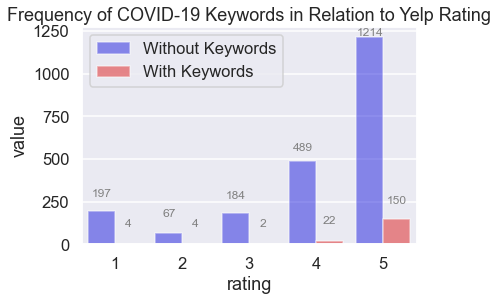

In [45]:
fig = sns.barplot(x ='rating',
                  y = 'value',
                  hue = 'variable',
                  data = combined_ratings_df,
                  palette=['blue', 'red'],
                  alpha = 0.5,
                  )
# graph formatting
plt.tight_layout
title = plt.title('Frequency of COVID-19 Keywords in Relation to Yelp Rating')
plt.xlabel = 'Rating'
plt.ylabel = 'Frequency'
plt.legend(loc='upper left')


# annotation of exact count/frequency of bar for better clarity
ax = fig
for p in ax.patches:
    ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2, (p.get_height()-(p.get_height()/13))),
                 ha = 'center', va='center', fontsize = 12, color ='gray', xytext=(0, 20),
                    textcoords = 'offset points') 


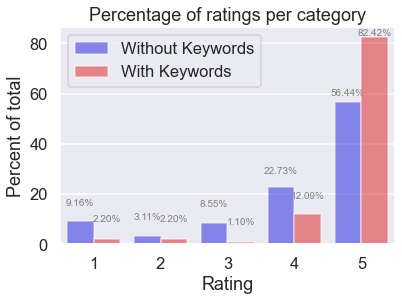

In [46]:
with_key_sum, without_key_sum = combined_ratings_df.groupby('variable')['value'].sum()

# split combined group into two for easy usage
wo_df = combined_ratings_df[combined_ratings_df['variable'] == 'Without Keywords']
w_df = combined_ratings_df[combined_ratings_df['variable'] == 'With Keywords']

val_list = []
# loop through values and turn them into % values based on the group they are in
for val in combined_ratings_df['value'].values:
    if val in w_df.values:
        val = val / with_key_sum
        val = val*100
    elif val in wo_df.values:
        val = val / without_key_sum
        val = val*100
    val_list.append(val)


combined_ratings_df['percent'] = val_list

fig2 = sns.barplot(x ='rating',
                  y = 'percent',
                  hue = 'variable',
                  data = combined_ratings_df,
                  palette=['blue', 'red'],
                  alpha = 0.5,
                  )

ax_2 = fig2
ax_2.set_xlabel('Rating')
ax_2.set_ylabel('Percent of total')
ax_2.set_title('Percentage of ratings per category')
ax_2.legend(loc='upper left')
for p in ax_2.patches:
    ax_2.annotate(('%.2f' % p.get_height())+'%', (p.get_x() + p.get_width() / 2, (p.get_height()-(p.get_height()/13))),
                 ha = 'center', va='center', fontsize = 10, color ='gray', xytext=(0, 20),
                    textcoords = 'offset points') 


In [47]:
# many issues getting infinite values for df using without keyword values
# as that dataframe as 2151 entries and np does not like to cooperate 
# so means are calculated in a somewhat 'hack-y' way
wo_mean = wo_df['rating'].values.astype('float64') * wo_df['percent'].values
wo_mean = wo_mean.sum()
wo_mean = wo_mean / 100

w_mean = w_df['rating'].values.astype('float64') * w_df['percent'].values
w_mean = w_mean.sum()
w_mean = w_mean / 100

print(wo_mean, w_mean)

# none of the 3 main sets of data are normally distributed
# thus t-testing does not give accurate information
normaltest(df_without_keywords['rating'].astype('int'))
normaltest(df['rating'].astype(int))
normaltest(df_with_keywords['rating'].astype(int))

# using permutation test to see if groups have similar distribution
p_val_from_test = permutation_test(df_without_keywords['rating'].values.astype(int), df_with_keywords['rating'].values.astype(int),
                                   method='approximate',num_rounds=10000,seed=0)
print('p-value: %.5f' % p_val_from_test)


4.141794514179451 4.7032967032967035


p-value: 0.00010


# Ethics & Privacy

There is quite a bit of yelp data available through their datasets that are made public for people who can work with JSON. This information does not contain any sensitive content about individuals. As this project only uses this information it does not contain any information pertaining to individuals and their privacy. This project was done with the goal of understanding change in ratings and ideally would not harm any individual or business. However, there have been instances in the past of Yelp attempting to threaten or intentionally damage small businesses that do not contribute to Yelp's business model. It is possible that if Yelp as a company had trend data showing that COVID-19 is potentially boosting ratings they could attempt to negate that effect or do something about it. It is also possible, I would even go as far to say that it is likely that Yelp is already doing this with their data.

# Conclusion & Discussion

After viewing the difference in means between the two subsamples of data, there is an increase in the rating of locations within San Diego when taking COVID-19 related keywords into consideration. Though this data is not normally distributed and a t-test is not viable, when using a permutation test the two sets have a very similar distribution. Therefore since the distribution is the same and the mean has risen by 0.56 on a scale of 1-5 that indicates that we should support the hypothesis that there is a relationship between covid-19 keywords and ratings on Yelp in San Diego. 